# Data

[PatchCamelyon](https://paperswithcode.com/dataset/pcam) is an image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than ImageNet, trainable on a single GPU.


In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os, datetime, time

path = './PCam/'

## load data

Since the dataset is over 200k, we take testing set (30k) as our sample dataset for this project as our train/test/val sets.

In [ ]:
# load data
from pickle import load
data = load(open(path + 'data/miniPcam_dict.pkl', 'rb'))

# unpack
x, y = data.values()

In [ ]:
print(x.shape)
print(y.shape)

(32768, 96, 96, 3)
(32768, 1)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Input 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, Nadam,Ftrl
from keras.layers import Dense, Conv2D, LSTM, Attention, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization, MaxPooling2D, Dropout
from keras.layers import Reshape, UpSampling2D
from tensorflow.keras.metrics import Accuracy,Precision,Recall,AUC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation,RandomTranslation,RandomFlip,RandomContrast,Resizing

## Pre-process

In [ ]:
# num_of_class
num_classes = 2

# one-hot
y = to_categorical(y, num_classes)

In [ ]:
y.shape

(32768, 2)

### split

In [ ]:
# 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2,
                                                    shuffle=True)

# reserve 6500 samples for validation
x_train = x_train[:-6500]
y_train = y_train[:-6500]
x_val = x_train[-6500:]
y_val = y_train[-6500:]

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(19714, 2)
(6500, 2)
(6554, 2)


### annotation / label encoder
Patches denotes the presence of tumour with a positive label whereas the other two have negative labels.

1 = tumor, 0 = normal

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(['Normal','Tumor'])
list(le.classes_)
# print(le.inverse_transform([0]))

['Normal', 'Tumor']

### stats

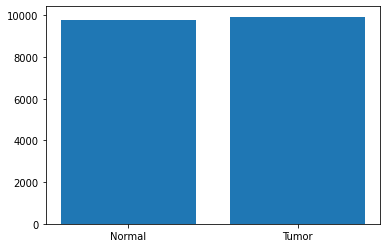

In [ ]:
# label distribution
label_df = pd.DataFrame(y_train.reshape(-1,2))
cat = list(le.classes_)
freq = np.sum(label_df, axis=0)

plt.bar(cat, freq)
plt.show()

In [ ]:
# training sample
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19714 entries, 0 to 19713
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       19714 non-null  float32
 1   1       19714 non-null  float32
dtypes: float32(2)
memory usage: 154.1 KB


### visualize sample

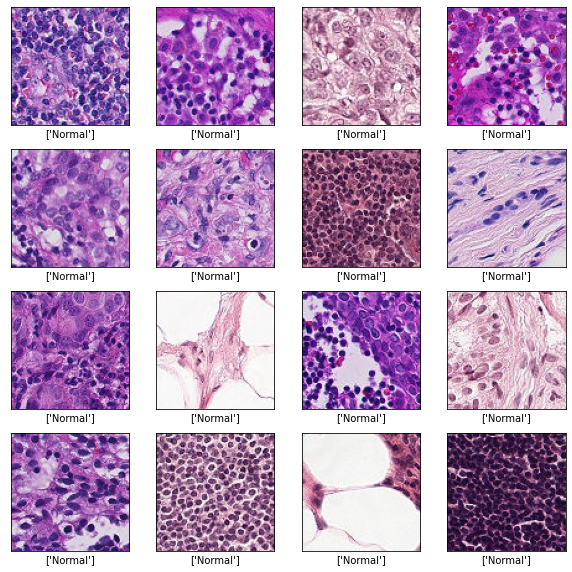

In [ ]:
# from tensorflow.keras.preprocessing import image

plt.figure(figsize=(10,10))
for i in range (16):
  plt.subplot(4,4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.array_to_img(x_test[i]))
  plt.xlabel(le.inverse_transform([np.argmax(y_test[i])]))
  # plt.xlabel(np.argmax(y_test[i]))

In [ ]:
y_train.shape

(19714, 2)

In [ ]:
# normal sample
label_df = pd.DataFrame(y_train.reshape(-1,2))
sum(label_df.iloc[:,0])

9774.0

In [ ]:
# tumor sample
label_df = pd.DataFrame(y_train.reshape(-1,2))
sum(label_df.iloc[:,1])

9940.0

In [ ]:
batch_size = 64
train_steps_per_epoch = len(x_train) // batch_size
valid_steps_per_epoch = len(x_val) // batch_size

In [ ]:
train_datagen = image.ImageDataGenerator(rescale=1.0/255.0,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         rotation_range=45,
                                         channel_shift_range=0.2,
                                         horizontal_flip=True)
test_datagen = image.ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
valid_generator = test_datagen.flow( x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [ ]:
# fist batch img, lable
valid_generator.()

64

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(19714, 96, 96, 3)
(19714, 2)
(6500, 96, 96, 3)
(6500, 2)
(6554, 96, 96, 3)
(6554, 2)


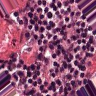

(64, 96, 96, 3)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img_path = path + '/images/'

# generate 1st random batch and save to folder
sample_imgs = next(train_datagen.flow(x_test, batch_size=64, shuffle=True,
                             save_to_dir= img_path, save_prefix='test_sample', save_format='jpeg'))

display(image.array_to_img(sample_imgs[0]))
print(sample_imgs.shape)

# MobileNetV2
MobileNetV2 is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

## M0: mobileNet2NN (75%)

Use mobileNetV2 as backbone

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

Epoch 1/20
308/308 [==============================] - 59s 177ms/step - loss: 0.5366 - accuracy: 0.7353 - auc_14: 0.8071 - precision_14: 0.7321 - recall_14: 0.7339 - true_negatives_14: 14373.0000 - true_positives_14: 14422.0000 - val_loss: 0.6947 - val_accuracy: 0.4972 - val_auc_14: 0.4972 - val_precision_14: 0.4972 - val_recall_14: 0.4972 - val_true_negatives_14: 3214.0000 - val_true_positives_14: 3214.0000
Epoch 2/20
308/308 [==============================] - 54s 175ms/step - loss: 0.4857 - accuracy: 0.7678 - auc_14: 0.8468 - precision_14: 0.7678 - recall_14: 0.7670 - true_negatives_14: 15091.0000 - true_positives_14: 15072.0000 - val_loss: 0.6940 - val_accuracy: 0.4968 - val_auc_14: 0.4968 - val_precision_14: 0.4968 - val_recall_14: 0.4968 - val_true_negatives_14: 3211.0000 - val_true_positives_14: 3211.0000
Epoch 3/20
308/308 [==============================] - 53s 173ms/step - loss: 0.4559 - accuracy: 0.7912 - auc_14: 0.8676 - precision_14: 0.7902 - recall_14: 0.7905 - true_negative

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 2s 22ms/step - loss: 0.5313 - accuracy: 0.7507 - auc_14: 0.8407 - precision_14: 0.7511 - recall_14: 0.7489 - true_negatives_14: 4928.0000 - true_positives_14: 4908.0000


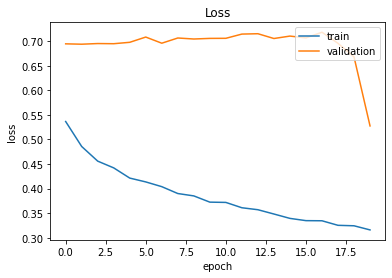

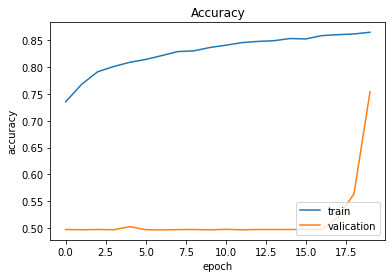

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'
n_epochs = 20

def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights=None)(inputs)
  return features

def classifier(inputs):
  x = layers.GlobalAveragePooling2D()(inputs)
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation=act)(x)
  x = layers.Dense(512, activation=act)(x)
  
  output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
  return output

def mobileNet2NN(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'mobileNet2NN'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= 'accuracy')
  
  return model

n_epochs = 20

def train_model(model):
    start = time.time()
    hist = model.fit(train_generator,
                     epochs = n_epochs,
                     verbose = 1, 
                     validation_data = valid_generator,
                     steps_per_epoch = train_steps_per_epoch,
                     validation_steps = valid_steps_per_epoch,
                     shuffle = True,
                     callbacks=callbacks)
    stop = time.time()
    training_time = stop - start
    print(f'Total training time = {training_time}s')
    return hist, model

def eval_model(model):
    score = model.evaluate(test_generator)
    return score

def run_all(model):
    hist, model = train_model(model)
    eval_model(model)
    return model

def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

inputs = Input(shape=(96,96,3))
mobileNet2NN = run_all(mobileNet2NN(2))

In [ ]:
m0.summary()

Model: "mobileNet2NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)              

## M1: selu_mobileNet2 (85%)


9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/20
308/308 [==============================] - 76s 225ms/step - loss: 0.3889 - accuracy: 0.8333 - auc_16: 0.9091 - precision_16: 0.8283 - recall_16: 0.8304 - true_negatives_16: 16267.0000 - true_positives_16: 16318.0000 - val_loss: 1.1328 - val_accuracy: 0.5707 - val_auc_16: 0.7080 - val_precision_16: 0.5763 - val_recall_16: 0.5574 - val_true_negatives_16: 3815.0000 - val_true_positives_16: 3603.0000
Epoch 2/20
308/308 [==============================] - 66s 213ms/step - loss: 0.3161 - accuracy: 0.8645 - auc_16: 0.9393 - precision_16: 0.8627 - recall_16: 0.8624 - true_negatives_16: 16952.0000 - true_positives_16: 16946.0000 - val_loss: 0.7674 - val_accuracy: 0.7347 - val_auc_16: 0.8125 - val_precision_16: 0.7381 - val_recall_16: 0.7212 - val_true_negatives_16: 4810.0000 - val_true_positives_16: 4662.0000
Epoch 3/20
308/308 [==============================] - 66s 214ms/step - loss: 0.2889 - accuracy: 0.8796 - auc_16: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PCam/models/selu_mobileNet2/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


103/103 [==============================] - 3s 29ms/step - loss: 0.3827 - accuracy: 0.8464 - auc_16: 0.9253 - precision_16: 0.8424 - recall_16: 0.8489 - true_negatives_16: 5513.0000 - true_positives_16: 5564.0000


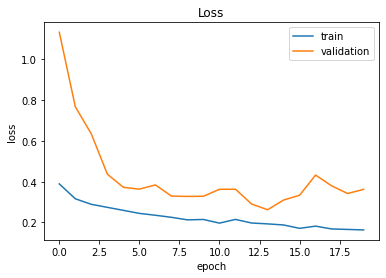

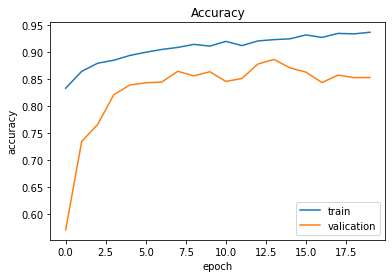

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'selu'
loss = 'binary_crossentropy'

n_epochs = 20

def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights='imagenet')(inputs)
  return features

def classifier(inputs):
  x = BatchNormalization()(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation=act)(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation=act)(x)
  x = BatchNormalization()(x)
  output = Dense(2, activation='sigmoid', name='predictions')(x)
  return output

def selu_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'selu_mobileNet2'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name='accuracy')
  model.compile(loss=loss, optimizer = opt, metrics= metrics)
  return model

# define input layer
inputs = Input(shape=(96,96,3))
selu_mobileNet2 = run_all(selu_mobileNet2(inputs))

## M2: elu_mobileNet2 (90%)

Epoch 1/20
308/308 [==============================] - 61s 181ms/step - loss: 0.3573 - accuracy: 0.8506 - auc_21: 0.9242 - precision_21: 0.8469 - recall_21: 0.8450 - true_negatives_21: 16649.0000 - true_positives_21: 16605.0000 - val_loss: 0.8888 - val_accuracy: 0.6965 - val_auc_21: 0.7949 - val_precision_21: 0.6951 - val_recall_21: 0.7056 - val_true_negatives_21: 4463.0000 - val_true_positives_21: 4561.0000
Epoch 2/20
308/308 [==============================] - 54s 175ms/step - loss: 0.2527 - accuracy: 0.8941 - auc_21: 0.9613 - precision_21: 0.8919 - recall_21: 0.8927 - true_negatives_21: 17523.0000 - true_positives_21: 17541.0000 - val_loss: 0.8577 - val_accuracy: 0.7389 - val_auc_21: 0.8242 - val_precision_21: 0.7378 - val_recall_21: 0.7420 - val_true_negatives_21: 4760.0000 - val_true_positives_21: 4796.0000
Epoch 3/20
308/308 [==============================] - 54s 176ms/step - loss: 0.2225 - accuracy: 0.9112 - auc_21: 0.9698 - precision_21: 0.9094 - recall_21: 0.9104 - true_negative

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 3s 24ms/step - loss: 0.2412 - accuracy: 0.9011 - auc_21: 0.9652 - precision_21: 0.8992 - recall_21: 0.9007 - true_negatives_21: 5892.0000 - true_positives_21: 5903.0000


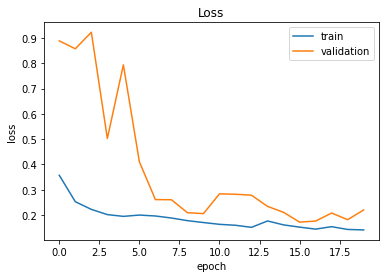

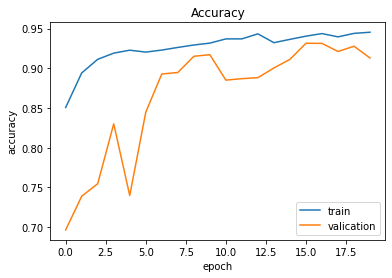

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'

n_epochs = 20

def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights='imagenet')(inputs)
  return features

def classifier(inputs):
  x = BatchNormalization()(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation=act)(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation=act)(x)
  x = BatchNormalization()(x)
  output = Dense(2, activation='sigmoid', name='predictions')(x)
  return output

def elu_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'elu_mobileNet2'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= 'accuracy')
  
  return model

elu_mobileNet2 = run_all(elu_mobileNet2())

In [ ]:
m2.summary()

Model: "elu_mobileNet2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 batch_normalization_12 (Bat  (None, 3, 3, 1280)       5120      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_10 (Flatten)        (None, 1280)              0         
                                                    

## M3: relu_mobileNet2 (89%)

Epoch 1/20
308/308 [==============================] - 60s 180ms/step - loss: 0.3367 - accuracy: 0.8520 - auc_22: 0.9302 - precision_22: 0.8528 - recall_22: 0.8507 - true_negatives_22: 16764.0000 - true_positives_22: 16716.0000 - val_loss: 1.8595 - val_accuracy: 0.5650 - val_auc_22: 0.6652 - val_precision_22: 0.5643 - val_recall_22: 0.5668 - val_true_negatives_22: 3635.0000 - val_true_positives_22: 3664.0000
Epoch 2/20
308/308 [==============================] - 54s 174ms/step - loss: 0.2293 - accuracy: 0.9066 - auc_22: 0.9679 - precision_22: 0.9065 - recall_22: 0.9060 - true_negatives_22: 17814.0000 - true_positives_22: 17803.0000 - val_loss: 1.9367 - val_accuracy: 0.5647 - val_auc_22: 0.6605 - val_precision_22: 0.5659 - val_recall_22: 0.5676 - val_true_negatives_22: 3650.0000 - val_true_positives_22: 3669.0000
Epoch 3/20
308/308 [==============================] - 53s 174ms/step - loss: 0.1975 - accuracy: 0.9224 - auc_22: 0.9760 - precision_22: 0.9226 - recall_22: 0.9217 - true_negative

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 2s 22ms/step - loss: 0.3609 - accuracy: 0.8898 - auc_22: 0.9493 - precision_22: 0.8891 - recall_22: 0.8904 - true_negatives_22: 5826.0000 - true_positives_22: 5836.0000


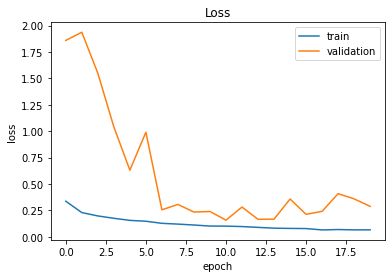

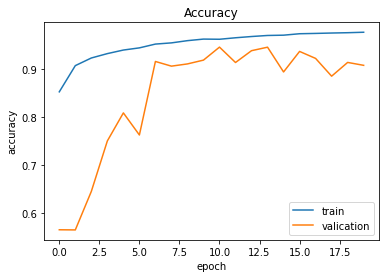

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'relu'
loss = 'binary_crossentropy'

n_epochs = 20 

def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights='imagenet')(inputs)
  return features

def classifier(inputs):
  x = layers.GlobalAveragePooling2D()(inputs)
  x = layers.Flatten()(x)
  
  x = layers.Dense(1024, activation=act)(x)
  x = layers.Dense(512, activation=act)(x)
  
  output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
  return output

def relu_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'relu_mobileNet2'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= 'accuracy')
  
  return model

# plot
def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()
    
# relu
relu_mobileNet2 = run_all(relu_mobileNet2())

## M4: CNN-LSTM (83%)

Model: "elu_mobileNet2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobileNet2NN (Functional)   (None, 2)                 4095554   
                                                                 
 reshape_46 (Reshape)        (None, 1, 1, 2)           0         
                                                                 
 up_sampling2d_22 (UpSamplin  (None, 96, 96, 2)        0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 94, 94, 64)        1216      
                                                                 
 conv2d_35 (Conv2D)          (None, 92, 92, 64)        36928     
                                               

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PCam/models/elu_mobileNet2_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PCam/models/elu_mobileNet2_lstm/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


103/103 [==============================] - 8s 76ms/step - loss: 0.3735 - accuracy: 0.8306 - auc_35: 0.9131 - precision_35: 0.8289 - recall_35: 0.8322 - true_negatives_35: 5428.0000 - true_positives_35: 5454.0000


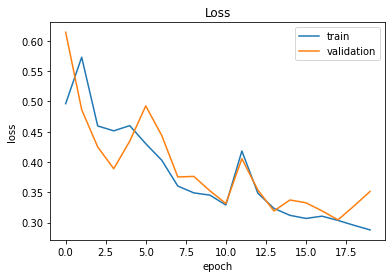

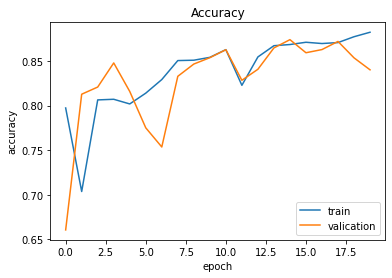

In [ ]:
INP_SIZE = (96,96)

lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'

n_epochs = 20

def elu_mobileNet2_lstm(input_shape=(INP_SIZE[0],INP_SIZE[1],3), n_class=2):    
    n_classes = n_class
    inputs = Input(shape=input_shape)
    model_name = 'elu_mobileNet2_lstm'
    
    mobileNet2NN = load_model(path + 'models/mobileNet2NN.h5') #. NN with (elu) output=2
    x = mobileNet2NN(inputs, training=False)
    
    x = Reshape((1,1,2))(x)
    x = UpSampling2D((96, 96))(x)
    x = Conv2D(64,3, activation=act)(x)
    x = Conv2D(64,3, activation=act)(x)
    x = MaxPooling2D(2)(x) 
    x = Reshape((-1,64))(x)
    x = LSTM(32)(x)
    x = Flatten()(x)
    outputs = layers.Dense(2, activation='sigmoid', name='pred')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= 'accuracy')
  
    return model

def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

elu_mobileNet2_lstm().summary()
run_all(elu_mobileNet2_lstm())

## M5: Double LSTM (50%)

In [ ]:
INP_SIZE = (96,96)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'relu'
loss = 'binary_crossentropy'

n_epochs = 20

def mobileNet2_lstm_var1(input_shape=(INP_SIZE[0],INP_SIZE[1],3), n_class=2):
    tf.autograph.experimental.do_not_convert(func=True)
    
    n_classes = n_class
    input_shape = input_shape
    model_name = 'mobileNet2_lstm_var1'
    
    mobileNet2NN = load_model(path + 'models/mobileNet2NN.h5') #. NN with (elu) output=2
    mobileNet2NN.summary()

    inputs = Input(shape=(INP_SIZE[0],INP_SIZE[1],3))
    x = mobileNet2NN(inputs, training=False)
    
    x = Reshape((1,1,2))(x)
    x = UpSampling2D((96, 96))(x)
    x = Conv2D(64,3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64,3)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.2)(x)
    x = Reshape((-1,64))(x)
    x = LSTM(32,return_sequences=True,)(x)
    x = LSTM(32)(x)
    outputs = layers.Dense(2, activation='sigmoid', name='pred')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= 'accuracy')
  
    return model

# plot
def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

mobileNet2_lstm_var1().summary()

Model: "mobileNet2NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_5 (Dense)             (None, 512)              

Model: "mobileNet2NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_5 (Dense)             (None, 512)              

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PCam/models/mobileNet2_lstm_var1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PCam/models/mobileNet2_lstm_var1/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


103/103 [==============================] - 12s 114ms/step - loss: 0.7448 - accuracy: 0.5085 - auc_2: 0.5085 - precision_2: 0.5085 - recall_2: 0.5085 - true_negatives_2: 3333.0000 - true_positives_2: 3333.0000


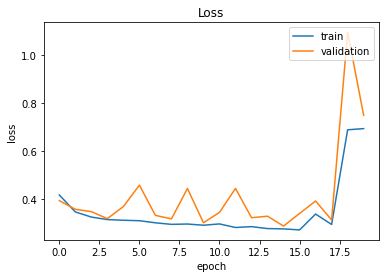

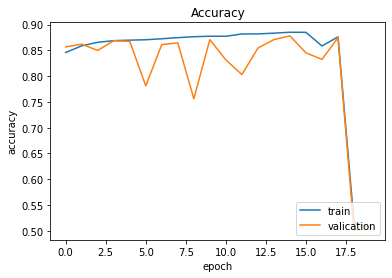

In [ ]:
run_all(mobileNet2_lstm_var1())

## M6: relu_mobileNet2_lstm (86%)

Model: "relu_mobileNet2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobileNet2NN (Functional)   (None, 2)                 4095554   
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 2)           0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 96, 96, 2)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 64)        1216      
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 64)        36928     
                                              

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 6s 60ms/step - loss: 0.3328 - accuracy: 0.8589 - auc_1: 0.9349 - precision_1: 0.8589 - recall_1: 0.8592 - true_negatives_1: 5629.0000 - true_positives_1: 5631.0000


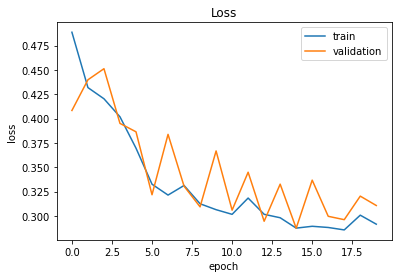

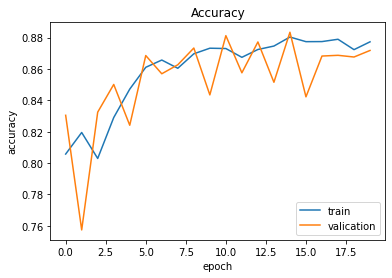

In [ ]:
INP_SIZE = (96,96)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'relu'
loss = 'binary_crossentropy'

n_epochs = 20

def relu_mobileNet2_lstm(input_shape=(INP_SIZE[0],INP_SIZE[1],3), n_class=2):
    tf.autograph.experimental.do_not_convert(func=True)
    
    n_classes = n_class
    inputs = Input(shape=input_shape)
    model_name = 'relu_mobileNet2_lstm'
    
    mobileNet2NN = load_model(path + 'models/mobileNet2NN.h5') 
    x = mobileNet2NN(inputs, training=False)
    
    x = Reshape((1,1,2))(x)
    x = UpSampling2D((96, 96))(x)
    x = Conv2D(64,3, activation=act)(x)
    x = Conv2D(64,3, activation=act)(x)
    x = MaxPooling2D(2)(x)
    x = Reshape((-1,64))(x)
    x = LSTM(32)(x)
    x = Flatten()(x)
    outputs = layers.Dense(2, activation='sigmoid', name='pred')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= 'accuracy')
  
    return model

# plot
def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

relu_mobileNet2_lstm().summary()
run_all(relu_mobileNet2_lstm())

## M7: elu_mobileNet2_lstm (87%)

Model: "elu_mobileNet2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobileNet2NN (Functional)   (None, 2)                 4095554   
                                                                 
 reshape_6 (Reshape)         (None, 1, 1, 2)           0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 96, 96, 2)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 94, 94, 64)        1216      
                                                                 
 conv2d_8 (Conv2D)           (None, 92, 92, 64)        36928     
                                               

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 6s 60ms/step - loss: 0.3036 - accuracy: 0.8715 - auc_2: 0.9440 - precision_2: 0.8709 - recall_2: 0.8731 - true_negatives_2: 5706.0000 - true_positives_2: 5722.0000


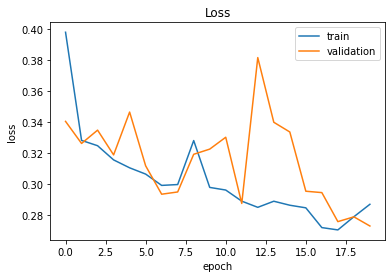

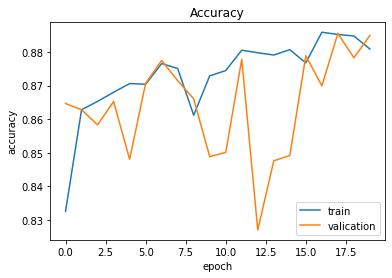

In [ ]:
INP_SIZE = (96,96)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'

n_epochs = 20

# build model
def elu_mobileNet2_lstm(input_shape=(INP_SIZE[0],INP_SIZE[1],3), n_class=2):
    tf.autograph.experimental.do_not_convert(func=True)
    
    n_classes = n_class
    inputs = Input(shape=input_shape)
    model_name = 'elu_mobileNet2_lstm'
    
    mobileNet2NN = load_model(path + 'models/mobileNet2NN.h5') #. NN with (elu) output=2
    x = mobileNet2NN(inputs, training=False)
    
    x = Reshape((1,1,2))(x) # new shape (224,224,3)
    x = UpSampling2D((96, 96))(x)
    x = Conv2D(64,3, activation=act)(x)
    x = Conv2D(64,3, activation=act)(x)
    x = MaxPooling2D(2)(x) #. shape = (None,46,46,64)
    x = Reshape((-1,64))(x) #. shape = (None,2116,46)
    x = LSTM(32)(x)
    x = Flatten()(x)
    outputs = layers.Dense(2, activation='sigmoid', name='pred')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= 'accuracy')
  
    return model

elu_mobileNet2_lstm().summary()
run_all(elu_mobileNet2_lstm())

## M8: relu_mobileNet2_simple_lstm (49%)

Model: "mobileNet2NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_5 (Dense)             (None, 512)              

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PCam/models/mobileNet2_relu_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PCam/models/mobileNet2_relu_lstm/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


103/103 [==============================] - 18s 176ms/step - loss: 0.6932 - accuracy: 0.4915 - auc_11: 0.5000 - precision_11: 0.4915 - recall_11: 0.4915 - true_negatives_11: 3221.0000 - true_positives_11: 3221.0000


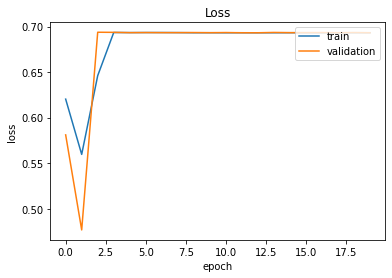

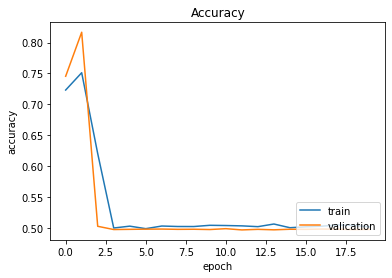

In [ ]:
INP_SIZE = (96,96)

lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'relu'
loss = 'binary_crossentropy'

n_epochs = 20

def relu_mobileNet2_simple_lstm(input_shape=(INP_SIZE[0],INP_SIZE[1],3), n_class=2):
    tf.autograph.experimental.do_not_convert(func=True)
    
    n_classes = n_class
    model_name = 'relu_mobileNet2_simple_lstm'
    
    mobileNet2NN = load_model(path + 'models/mobileNet2NN.h5')

    inputs = Input(shape=input_shape)
    x = mobileNet2NN(inputs, training=False)
    
    x = Reshape((1,1,2))(x)
    x = UpSampling2D((96, 96))(x)
    x = Reshape((-1,2))(x)
    x = LSTM(32)(x)
    outputs = layers.Dense(2, activation='sigmoid', name='pred')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= 'accuracy')
  
    return model

relu_mobileNet2_simple_lstm().summary()
run_all(relu_mobileNet2_simple_lstm())